In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/borsa_study

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/borsa_study


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
prices = pd.read_csv('other_data/values-of-top-nasdaq-companies-from-2010-to-2020/CompanyValues.csv')
prices['day_date'] = pd.to_datetime(prices['day_date'], format="%Y-%m-%d").dt.date.astype('datetime64[ns]')
prices = prices.sort_values(by=['day_date']).reset_index()
prices = prices.rename(columns={'day_date':'date'})

In [4]:
def create_indicators(data):
  prices = data.sort_values(by=['date']).reset_index()
  n=[10,20,50,100]
  for i in n:
    prices.loc[:,(str("MA"+str(i)))]=prices['close_value'].rolling(i).mean()
  day26 = prices['close_value'].ewm(span=26, adjust=False).mean()
  day12 = prices['close_value'].ewm(span=12, adjust=False).mean()
  prices.loc[:,('macd')]=day12-day26
  prices.loc[:,('signal')]=prices['macd'].ewm(span=9,adjust=False).mean()

  #RSI calculation
  up=np.log(prices.close_value).diff(1)
  down=np.log(prices.close_value).diff(1)
  up[up<0]=0
  down[down>0]=0

  #calculate EMA
  roll_up=up.ewm(span=14).mean()
  roll_down=down.abs().ewm(span=14).mean()

  RS1=roll_up/roll_down
  RSI1=100.0-(100.0/(1.0+RS1))
  prices.loc[:,('rsi')]=RSI1

  return prices

In [5]:
d = dict(tuple(prices.groupby('ticker_symbol')))
d = {k:create_indicators(v) for k, v in d.items()}

In [6]:
def subset_prices(d,ticker,start,end):
  x=d[ticker]
  x=x[((x.date>=start)&(x.date<=end))]
  return x

In [7]:
# import tweets
tweets=pd.read_csv('other_data/tweets-about-to-companies-from-2015-to-2020/Tweet.csv')
company_tweet=pd.read_csv('other_data/tweets-about-to-companies-from-2015-to-2020/Company_Tweet.csv')

tweets=tweets.merge(company_tweet,how='left',on='tweet_id')
# format dates
tweets['date'] = pd.to_datetime(tweets['post_date'], unit='s').dt.date
tweets.date=pd.to_datetime( tweets.date,errors='coerce')
tweets['time'] = pd.to_datetime(tweets['post_date'], unit='s').dt.time

In [8]:
tweets.head(2)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,date,time
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01,00:00:57
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01,00:01:36


In [9]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(tweets,ticker='TSLA',start='2017-01-01',end='2017-02-01'):
    #sbuset
    df=tweets.loc[((tweets.ticker_symbol==ticker)&(tweets.date>=start)&(tweets.date<=end))]
    # applt the SentimentIntensityAnalyzer
    df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
    # create label
    #bins= pd.interval_range(start=-1, freq=3, end=1)
    df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
    
    df=df.loc[:,["date","score","label","tweet_id","body"]]
    return df

print('tesla misses earnings, analyst suggest downgrade , sell now ')
sia.polarity_scores('tesla misses earnings, analyst suggest downgrade , sell now ')

tesla misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}

In [10]:
# augment vocab

positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller '

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}

sia.lexicon.update(Financial_Lexicon)


print('tesla misses earnings, analyst suggest downgrade , sell now ')
sia.polarity_scores('tesla misses earnings, analyst suggest downgrade , sell now ')

tesla misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.535, 'neu': 0.465, 'pos': 0.0, 'compound': -0.7845}

In [11]:
## Sentiment from Price
def price_plot_ma(df,ax=None, **plt_kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr

    n = df.shape[0] # number of dates
    if ax is None:
        ax = plt.gca()
        
    # format data for seaborn
    df=df.melt(id_vars='date',var_name='var', value_name='vals')
    df=df[df['var'].isin(['close_value','MA10','MA20','MA50','MA100'])]
    df['vals']=df['vals'].astype(float)
    df.index=df.date.dt.date
    df.date=df.date.dt.date
    # set axis formats / Set the locator
    if ax is None:
        ax = plt.gca()
        
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
        
    

        
    ax.set_ylabel('Close Price')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    sns.lineplot(data=df, x='date', y='vals',hue='var',palette='cool_r',ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=True)
    return ax

In [12]:
def price_plot_vol(df,ax=None, **plt_kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr
    
    n=df.shape[0]
    
    df.index=df.date.dt.date
    if ax is None:
        ax = plt.gca()
    
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
        
    
    ax.set_ylabel('Traded Volume (million)')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))
    sns.lineplot(data=df, x='date', y='volume',palette='cool_r',ax=ax)

    return ax

In [13]:
def sentiment_barplot(df,ax=None, **plt_kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr
    
    df=df.groupby(['date','label'])['tweet_id'].agg('count').reset_index(name="count")
    
    n=len(df.date.unique())
    
    # format the data and make proportion
    df=df.pivot(index='date',columns='label',values='count')
    df=pd.DataFrame(df.to_records()).reset_index()
    df.loc[:,"total"]=df.loc[:,['bad','neutral','good']].sum(axis=1)
    df.loc[:,['bad','neutral','good']]=df.loc[:,['bad','neutral','good']].div(df.total,axis=0)
    df.loc[:,"total"]=df.loc[:,['bad','neutral','good']].sum(axis=1)
    df=df.drop(['total'], axis=1)
   
    df.index=df.date.dt.date
    if ax is None:
        ax = plt.gca()
    colors=['crimson','lightgrey','mediumseagreen']
    df.loc[:,['bad','neutral', 'good']].plot.bar(stacked=True, color=colors, width=1.0,alpha=0.5,ax=ax)
    
   
    # set axis formats / Set the locato
    
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
         
    
    ax.set_ylabel('Sentiment')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    
    ax.grid(True, which='major',axis='both')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=True)
    return ax

In [14]:
def sentiment_tweet_vol(df,ax=None,**kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr
    df=df.groupby(['date'])['label'].agg('count').reset_index(name="count")
    df.index=df.date.dt.date
    n=len(df.date.unique())
    
    if ax is None:
        ax = plt.gca()
    # set axis formats / Set the locator
    
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
        
    ax.set_ylabel('Tweet Volume')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    sns.lineplot(data=df, x='date', y='count',palette='cool_r',ax=ax)
    
    return ax

In [36]:
def corr_plot(sp,tw):
    
    x=tw.groupby(['date','label']).agg({"score":['count','mean']}).unstack('label') 
    sp=sp.reset_index(drop=True)
    # format the data and make proportion
    x=pd.DataFrame(x.to_records())
    # format columns names
    x.columns=['date','count_bad','count_neutral','count_good','score_mean_bad','score_mean_neutral','score_mean_good']
    x.loc[:,'tweet_volume']=x.loc[:,['count_bad','count_neutral','count_good']].sum(axis=1)
    x.loc[:,'count_ratio_gb']=x.count_good/x.count_bad # create a ratio good:bad
    # join price
    x=x.merge(sp.loc[:,['date','MA10', 'MA20', 'MA50','MA100', 'macd', 'rsi','volume']],how='left',left_on='date',right_on='date')

    corr = x.corr()
    # Getting the Upper Triangle of the co-relation matrix
    matrix = np.triu(corr)
    ax = sns.heatmap(
        round(corr,3),
        vmin=-1, vmax=1, center=0,
        cmap="YlGnBu",annot=True,annot_kws={"fontsize":8}, fmt=".2",
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    return ax

ValueError: ignored

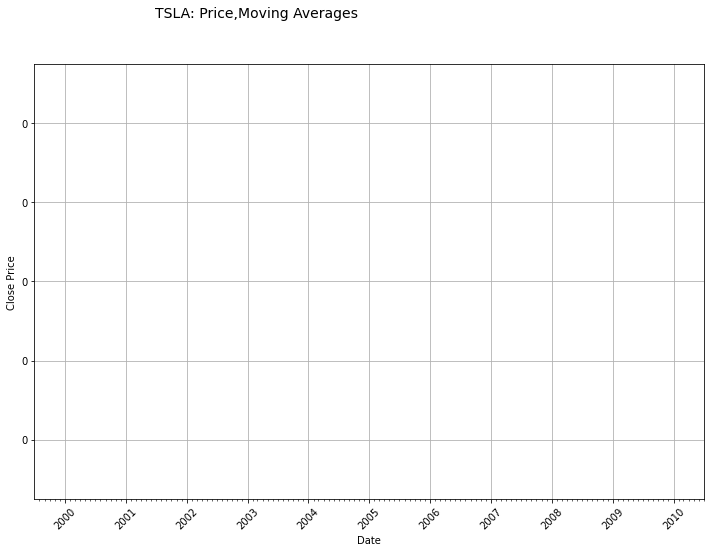

In [37]:
start='2015-01-01'
end='2020-12-31'
ticker='TSLA'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
sp = sp.rename(columns={'index':'index1'})
fig,ax=plt.subplots(figsize=(12, 8))
fig.suptitle(ticker+ ": Price,Moving Averages",fontsize=14,horizontalalignment='right', verticalalignment='top')
price_plot_ma(ax=ax,df=sp)

In [34]:
sp.head()

,level_0,index,ticker_symbol,date,close_value,volume,open_value,high_value,low_value,MA10,MA20,MA50,MA100,macd,signal,rsi
1136,5956,16960,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.2500,222.396,217.0295,232.0514,244.3524,-2.554542,-4.566043,53.36039
1137,5963,15823,TSLA,2015-01-02,219.31,4753239,222.87,223.25,213.2600,222.501,216.5810,231.8156,243.9459,-2.519732,-4.156781,45.91881
1138,5968,16961,TSLA,2015-01-03,219.31,4753239,222.87,223.25,213.2600,222.503,216.3610,231.4960,243.5359,-2.463744,-3.818174,45.91881
1139,5973,16962,TSLA,2015-01-04,219.31,4753239,222.87,223.25,213.2600,222.174,216.6085,231.1774,243.1152,-2.391803,-3.532900,45.91881
1140,5978,15822,TSLA,2015-01-05,210.09,5355485,214.55,216.50,207.1626,221.086,216.2685,230.9458,242.5960,-3.043679,-3.435055,27.73634


In [ ]:
start='2018-06-01'
end='2019-12-31'
ticker='TSLA'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
tw=get_sentiment(tweets,ticker,start,end) # get tweets
gridsize = (3, 2) # 3 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Price,Moving Averages & Twitter Sentimet",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.4)
price_plot_ma(ax=ax1,df=sp)
sentiment_barplot(ax=ax2,df=tw)